In [1]:
import pandas as pd
import numpy as np

In [2]:
data_set_test = pd.read_csv('twitter_training.csv')
data_set_validation = pd.read_csv('twitter_validation.csv')

df = pd.concat([data_set_validation, data_set_test], ignore_index=True)

In [3]:
df.head()

,id,borderland,emotion,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          75682 non-null  int64 
 1   borderland  75682 non-null  object
 2   emotion     75682 non-null  object
 3   text        74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
df['emotion'].describe()

count        75682
unique           4
top       Negative
freq         22808
Name: emotion, dtype: object

<Axes: xlabel='emotion'>

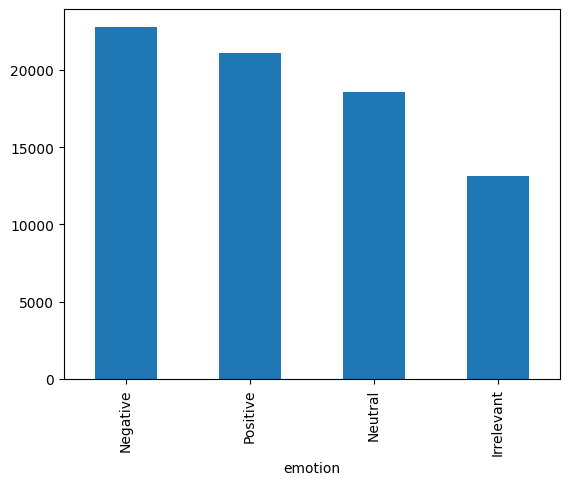

In [6]:
df['emotion'].value_counts().plot(kind='bar')

Hay un desbalance pero no es preocupante

In [7]:
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
stop_words_en = set(stopwords.words('english'))
import spacy
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jyaruhernandez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jyaruhernandez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jyaruhernandez/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jyaruhernandez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def clean(text):
    text = str(text)
    text = text.lower()
    text = text.strip()
    text = text.replace('\n', '')
    text = text.replace('\t', '')
    text = re.sub(r'[^\w\s]','',text)
    text = word_tokenize(text)
    text = [palabra for palabra in text if palabra not in stop_words_en]
    text = [lemmatizer.lemmatize(palabra) for palabra in text]
    text = ' '.join(text)
    return text

In [9]:
df['clean_text'] = df['text'].apply(clean)

In [10]:
df['clean_text'].head()

0    mentioned facebook struggling motivation go ru...
1    bbc news amazon bos jeff bezos reject claim co...
2    microsoft pay word function poorly samsungus c...
3    csgo matchmaking full closet hacking truly awf...
4    president slapping american face really commit...
Name: clean_text, dtype: object

In [11]:
def vectorize(text):
    vector = nlp(text).vector
    return vector

In [12]:
df['vector'] = df['clean_text'].apply(vectorize)

In [13]:
X = df['vector']

In [14]:
X = np.concatenate(X).reshape(-1,300)

In [15]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import seaborn as sns

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [17]:
y = df['emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
mapper_y = {'Irrelevant':0, 'Neutral':0, 'Negative':1, 'Positive':2}
y_train = y_train.map(mapper_y)
y_test = y_test.map(mapper_y)

In [19]:
y_train = to_categorical(y_train,3)
y_test = to_categorical(y_test,3)

In [20]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
model = Sequential()

In [22]:
model.add(Conv1D(64,5,activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train, epochs=300, batch_size=60, validation_data=[X_test,y_test], callbacks=[early_stopping])

Epoch 1/300
1010/1010 [==============================] - 4s 4ms/step - loss: 1.2138 - accuracy: 0.4123 - val_loss: 1.1723 - val_accuracy: 0.4523
Epoch 2/300
1010/1010 [==============================] - 4s 3ms/step - loss: 1.1685 - accuracy: 0.4530 - val_loss: 1.1390 - val_accuracy: 0.4740
Epoch 3/300
1010/1010 [==============================] - 4s 4ms/step - loss: 1.1453 - accuracy: 0.4726 - val_loss: 1.1130 - val_accuracy: 0.5019
Epoch 4/300
1010/1010 [==============================] - 6s 6ms/step - loss: 1.1225 - accuracy: 0.4891 - val_loss: 1.0936 - val_accuracy: 0.5167
Epoch 5/300
1010/1010 [==============================] - 4s 4ms/step - loss: 1.1056 - accuracy: 0.5001 - val_loss: 1.0751 - val_accuracy: 0.5395
Epoch 6/300
1010/1010 [==============================] - 4s 4ms/step - loss: 1.0896 - accuracy: 0.5105 - val_loss: 1.0599 - val_accuracy: 0.5450
Epoch 7/300
1010/1010 [==============================] - 5s 5ms/step - loss: 1.0776 - accuracy: 0.5182 - val_loss: 1.0469 - val_ac

In [24]:
history_df = pd.DataFrame(history.history)

<Axes: >

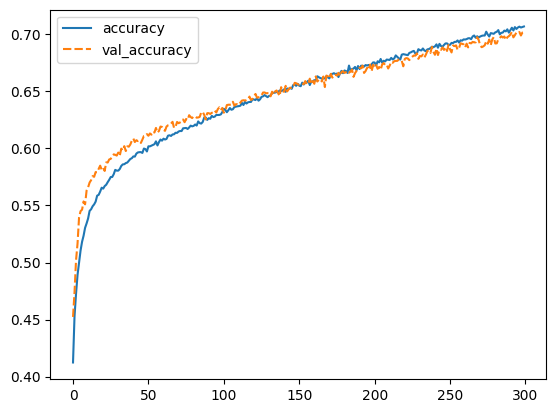

In [25]:
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])

<Axes: >

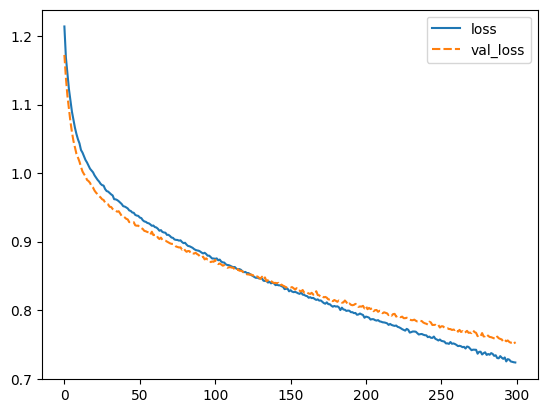

In [26]:
sns.lineplot(data=history_df[['loss', 'val_loss']])

In [27]:
model.evaluate(X_test, y_test)

474/474 [==============================] - 1s 1ms/step - loss: 0.7513 - accuracy: 0.7022


[0.7512656450271606, 0.7021867036819458]

In [28]:
from sklearn.metrics import classification_report

In [29]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

474/474 [==============================] - 1s 1ms/step


In [30]:
y_test = np.argmax(y_test, axis=-1)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.75      0.72      6353
           1       0.72      0.69      0.71      4562
           2       0.71      0.63      0.67      4222

    accuracy                           0.70     15137
   macro avg       0.71      0.69      0.70     15137
weighted avg       0.70      0.70      0.70     15137



In [32]:
def clasifica_texto(texto):
    texto = clean(texto)
    vector = vectorize(texto)
    vector = vector.reshape(1,300,1)
    return np.argmax(model.predict(vector), axis=-1)

In [33]:
clasifica_texto('''Grok Actually surpasses all A.I and completely outperforms them by a mile..''')

1/1 [==============================] - 0s 12ms/step


array([1])

Creamos el pipeline para exportarlo

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [35]:
def clean_vectorize(text):
    text = clean(text)
    vector = vectorize(text)
    vector = vector.reshape(1,300,1)
    return vector

transformer = FunctionTransformer(clean_vectorize)

In [36]:
pipeline_exportacion = Pipeline([
    ('preprocessing', transformer),
    ('model', model)
])

In [37]:
res = pipeline_exportacion.predict('''I think the world is going to be a better place because of you.''')

1/1 [==============================] - 0s 9ms/step


In [44]:
res.argmax()

2

In [45]:
model.save('sentiment_classifier.h5')

/Users/jyaruhernandez/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
from tensorflow.keras.models import load_model

In [47]:
modelo_importado = load_model('sentiment_classifier.h5')